In [1]:
%matplotlib inline
datadir = './data/'

import urllib.request, os, gzip

def download_data(dataset_name, datadir):
    filename = 'reviews_%s_5.json' % dataset_name
    filepath = os.path.join(datadir, filename)
    if os.path.exists(filepath):
        print("Dataset %s has already been downloaded to %s" % (dataset_name, datadir))
    else:
        url = 'http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/%s.gz' % filename
        urllib.request.urlretrieve(url, filepath + ".gz")
        with gzip.open(filepath + ".gz", 'rb') as fin:
            with open(filepath, 'wb') as fout:
                fout.write(fin.read())
        print("Downloaded dataset %s and saved it to %s" % (dataset_name, datadir))

#dataset = "Beauty"
#download_data(dataset, datadir)
dataset = "Apps_for_Android"
download_data(dataset, datadir)

Dataset Apps_for_Android has already been downloaded to ./data/


In [2]:
##reading the data to a variable called data[]
import json

def load_data(dataset_name,datadir):
    filepath = os.path.join(datadir, 'reviews_%s_5.json' % dataset_name)
    if not os.path.exists(filepath):
        download_data(dataset_name,datadir)
    data=[]
    with open(filepath, 'r') as f:
        for line in f:                   # read file line by line
            item_hash = hash(line)       # we will use this later for partitioning our data 
            item = json.loads(line)      # convert JSON string to Python dict
            item['hash'] = item_hash     # add hash for identification purpose
            data.append(item)
    print("Loaded %d data for datasets %s" % (len(data), dataset_name))
    return data

In [3]:
# load the data...
apps = load_data(dataset, datadir)
# ... and have a look at an example item (item number 9426):
print(apps[367668])

Loaded 752937 data for datasets Apps_for_Android
{'reviewerID': 'A2RK3QEUEFRNAN', 'asin': 'B008S3EJSU', 'reviewerName': 'Daddy Shawn "Writer & daddy."', 'helpful': [3, 3], 'reviewText': "Totally worth the $2.99 I paid.  Lots of fun if you're a fan of fantasy RPGs.  And it's a full game, you don't have to keep buying items with real money to continue.  That's refreshing in this horrible age of micro-transactions.  Pick it up.  You do need a good amount of space available on your device, but it's not as bad as the Final Fantasy games.  For those with new Kindles you won't have any problem.  If you've got an older model you may need to clear out some old games that you don't play.", 'overall': 5.0, 'summary': 'Awesome game & a blast from the past.', 'unixReviewTime': 1395187200, 'reviewTime': '03 19, 2014', 'hash': -792307445}


In [5]:
def partition_train_validation_test(data):
    # 60% : modulus is 0, 1, 2, 3, 4, or 5
    data_train = [item for item in data if item['hash']%10<=5]  
    # 20% : modulus is 6 or 7
    data_valid = [item for item in data if item['hash']%10 in [6,7]] 
    # 20% : modulus is 8 or 9
    data_test  = [item for item in data if item['hash']%10 in [8,9]] 
    return data_train, data_valid, data_test
    
apps_train, apps_valid, apps_test = partition_train_validation_test(apps)

print("Now we have", len(apps_train), "training examples,", len(apps_valid),
      "validation examples, and", len(apps_test), "test examples")

Now we have 452300 training examples, 150146 validation examples, and 150491 test examples


In [2]:
from nltk.corpus import opinion_lexicon
positive_words = set(opinion_lexicon.positive())
negative_words = set(opinion_lexicon.negative())

In [7]:
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize

eng_stopwords = set(stopwords.words('english'))

def my_tokenize(text):
    # split text into lower-case tokens, removing all-punctuation tokens and stopwords
    tokens = []
    for sentence in sent_tokenize(text):
        tokens.extend(x for x in word_tokenize(sentence.lower()) 
                      if x not in eng_stopwords and any(i.isalpha() for i in x)) #any means the word has atleast 1 alphabet
    return tokens

def pos_neg_fraction(text):
    tokens = my_tokenize(text)
    count_pos, count_neg = 0, 0
    for t in tokens:
        if t in positive_words:
            count_pos += 1
        if t in negative_words:
            count_neg += 1
    count_all = len(tokens)
    if count_all != 0:
        return count_pos/count_all, count_neg/count_all ## notice returning a pair
    else:
        return 0., 0.
    
pos_example = 'This is a good, great, fantastic, amazing, wonderful, super product!!!'
neg_example = 'This is a bad, atrocious, terrible, dreadful, awful, abysmal product!!!'
print(pos_neg_fraction(pos_example))
print(pos_neg_fraction(neg_example))

(0.8571428571428571, 0.0)
(0.0, 0.8571428571428571)


## X_train

In [8]:
##THIS BLOCK TAKES YEARS TO EXECUTE
import numpy

def dataset_to_matrix(data):
    return numpy.array([list(pos_neg_fraction(item['reviewText'])) for item in data])

X_train = dataset_to_matrix(apps_train)

##### loking at the most positive and most negative review

In [9]:
most_pos, most_neg = numpy.argmax(X_train, axis=0) #axis=0 means along columns, axis=1 means along rows
# print the example with the highest fraction of positive words:
print("We found a fraction of %f %% positive words for example %d" % 
      (100.*X_train[most_pos, 0], most_pos)) ## this means taking the value of id 'most_pos' from the 0th column
print(apps_train[most_pos])
print("We found a fraction of %f %% negative words for example %d" %
      (100.*X_train[most_neg, 1], most_neg)) ## this means taking the value of id 'most_neg' from the 1st column
print(apps_train[most_neg])

We found a fraction of 100.000000 % positive words for example 853
{'reviewerID': 'AWUDE6LOH5Y2Q', 'asin': 'B004DLPXAO', 'reviewerName': 'Amazon Customer', 'helpful': [0, 0], 'reviewText': 'Love it!', 'overall': 5.0, 'summary': 'Take you Kindle Library along whenever you have your phone!', 'unixReviewTime': 1404691200, 'reviewTime': '07 7, 2014', 'hash': 78475245}
We found a fraction of 100.000000 % negative words for example 6520
{'reviewerID': 'A1HZYCWWJ53TS5', 'asin': 'B004HE5TAG', 'helpful': [0, 0], 'reviewText': 'boring', 'overall': 2.0, 'summary': 'Two Stars', 'unixReviewTime': 1405382400, 'reviewTime': '07 15, 2014', 'hash': 2027779230}


## Y_train

In [10]:
def dataset_to_targets(data):
    return numpy.array([item['overall'] for item in data])

Y_train = dataset_to_targets(apps_train)
print("Our feature matrix is two-dimensional and has shape", X_train.shape)
print("Our target vector is one-dimensional and has shape", Y_train.shape)

Our feature matrix is two-dimensional and has shape (452300, 2)
Our target vector is one-dimensional and has shape (452300,)


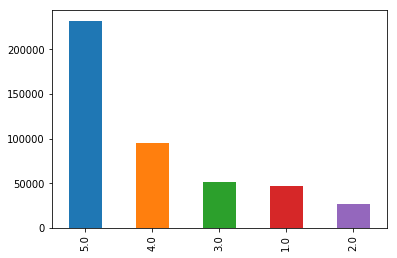

In [11]:
import pandas ## pip3 install pandas, this killed my day had to put the "3"
pandas.Series((Y_train)).value_counts().plot.bar()

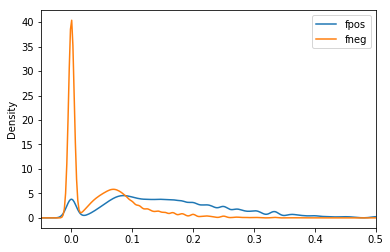

In [14]:
df = pandas.DataFrame(data=X_train, columns = ['fpos', 'fneg'])
df.plot.kde(xlim=(-0.05, 0.5))

In [16]:
from sklearn.linear_model import LinearRegression
lreg = LinearRegression().fit(X_train, Y_train)

print("The coefficient for the fpos variable is", lreg.coef_[0])
print("The coefficient for the fneg variable is", lreg.coef_[1])
print("The intercept is", lreg.intercept_)

The coefficient for the fpos variable is 3.7752470940645044
The coefficient for the fneg variable is -3.9353508131984425
The intercept is 3.5444536500987454


In [17]:
features = [[0.2, 0]]
expected_rating_A = lreg.predict(features)[0]
print("The expected rating is %f stars" % expected_rating_A)
# we can also compute this explicitly:
expected_rating_B = lreg.intercept_ + 0.2*lreg.coef_[0] + 0*lreg.coef_[1]
print("This is the same as %f stars" % expected_rating_B)

The expected rating is 4.299503 stars
This is the same as 4.299503 stars


In [19]:
features = [[0, 0.2]]
expected_rating_A = lreg.predict(features)[0]
print("The expected rating is %f stars" % expected_rating_A)
# we can also compute this explicitly:
expected_rating_B = lreg.intercept_ + 0 * lreg.coef_[0] + 0.2 * lreg.coef_[1]
print("This is the same as %f stars" % expected_rating_B)

The expected rating is 2.757383 stars
This is the same as 2.757383 stars


# Intermediate homework:
- calculate the prediction for 100% pos, and 100% neg review
- repeat this same process for "Apps for Android" dataset

### 100% positive

In [24]:
features = [[1, 0]]
expected_rating_A = lreg.predict(features)[0]
print("The expected rating is %f stars" % expected_rating_A)
# we can also compute this explicitly:
expected_rating_B = lreg.intercept_ + 1*lreg.coef_[0] + 0*lreg.coef_[1]
print("This is the same as %f stars" % expected_rating_B)

The expected rating is 7.319701 stars
This is the same as 7.319701 stars


### 100% negative

In [25]:
features = [[0,1]]
expected_rating_A = lreg.predict(features)[0]
print("The expected rating is %f stars" % expected_rating_A)
# we can also compute this explicitly:
expected_rating_B = lreg.intercept_ + 0*lreg.coef_[0] + 1*lreg.coef_[1]
print("This is the same as %f stars" % expected_rating_B)

The expected rating is -0.390897 stars
This is the same as -0.390897 stars


### Make modified corrected predictor

In [28]:
def predict_lreg(features):
    expected_rating = lreg.predict(features)
    expected_rating[expected_rating > 5.0] = 5.0
    expected_rating[expected_rating < 1.0] = 1.0
    return expected_rating

pred_train = predict_lreg(X_train) ##predicted the whole training set

### Trying the extremes again: 
(max 5 star, min 1 star)

In [26]:
predict_lreg([[1,0]]) #100% pos

array([5.])

In [27]:
predict_lreg([[0,1]]) #100% pos

array([1.])

### Manual error checking

In [30]:
def analyze_training_example(i):
    print("Training example number", i)
    print("True rating = %f stars, expected rating = %f stars" % (Y_train[i], 
                                                                  pred_train[i]))
    print("Features = %f / %f" % (X_train[i,0], X_train[i,1]))
    print("Review text = %s" % apps_train[i]['reviewText'])

for i in [0, 10000, 20000, 30000, 50000]: #some random numbers
    analyze_training_example(i)

Training example number 0
True rating = 3.000000 stars, expected rating = 4.230862 stars
Features = 0.181818 / 0.000000
Review text = Loves the song, so he really couldn't wait to play this. A little less interesting for him so he doesn't play long, but he is almost 3 and likes to play the older games, but really cute for a younger child.
Training example number 10000
True rating = 3.000000 stars, expected rating = 3.996347 stars
Features = 0.250000 / 0.125000
Review text = Repetitive after a few levels. Explosions should be more powerful. Its ok but could be better. that is all I have to say.
Training example number 20000
True rating = 4.000000 stars, expected rating = 3.824102 stars
Features = 0.074074 / 0.000000
Review text = This app works quite well on my Kindle Fire. It also manages to view some folders that don't even show up on some of the other file management apps I've tried.The only feature it could use is the ability to select multiple files if you need to move/delete them.

In [31]:
#trying to see why the predictor predicts 3.538736 star to a 5 star, in number 30000
str="Have XM radio in the car while driving. Usually miss the ending. But with this I get the whole show while I relaxing and taking a shower..This is the best appI've ever had. Use while waiting for the doc and last week me and the doc listened to Dragnet. He's putting it on his devise too"

def pos_neg_words_show(text):
    tokens = my_tokenize(text)
    pos=[]
    neg=[]
    for t in tokens:
        if t in positive_words:
            pos.append(t)
        if t in negative_words:
            pos.append(t)
    print(pos)
    print(neg)

pos_neg_words_show(str)

['miss', 'best']
[]


so looks like the above example simply didnt have enough "Positive" words. so "no negative words" didnt help improve the rating

In [36]:
from  sklearn.metrics import mean_absolute_error
mae_train = mean_absolute_error(pred_train, Y_train)
print("The mean absolute error on the training data is %f stars" % mae_train)

The mean absolute error on the training data is 0.992480 stars


# 99.248% ERROR !!! So Useless!!!